# A behavioural analog to BCI training : results

Statistics and simple plots of the results of the experiment (technical test). 

This notebook does not figure much computational modeling (yet).


Let's start by importing the necessary packages as well as the data : 

 - Loaded the task results for study 66f96c31e69227986334a027 
    (16 subjects.)
 - Loaded the task results for study 66d086503c0a69291c361b67 
    (40 subjects.)
Total : 56 subjects
55 subjects remaining after removing problematic subjects.
A total of 14/6050 actions were missed. (0.23 %)
 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.
A total of 33/15950 actions were missed. (0.21 %)
(200, 3)


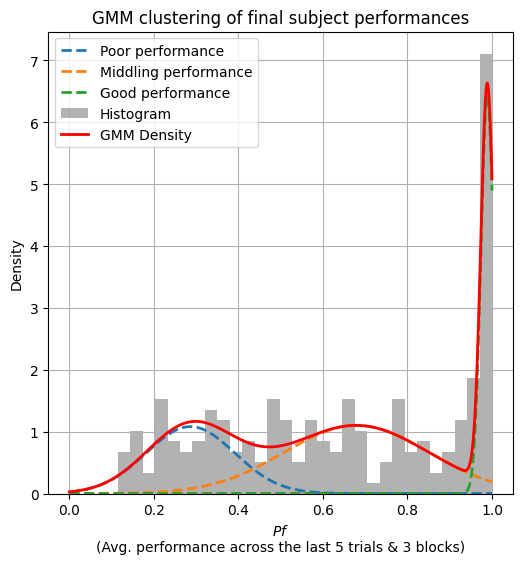

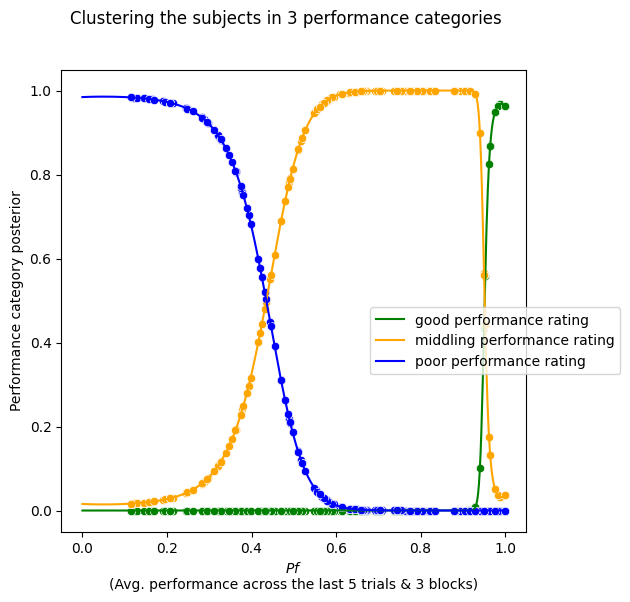

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\analysis_tools\dataframe_from_raw_data.py:348: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


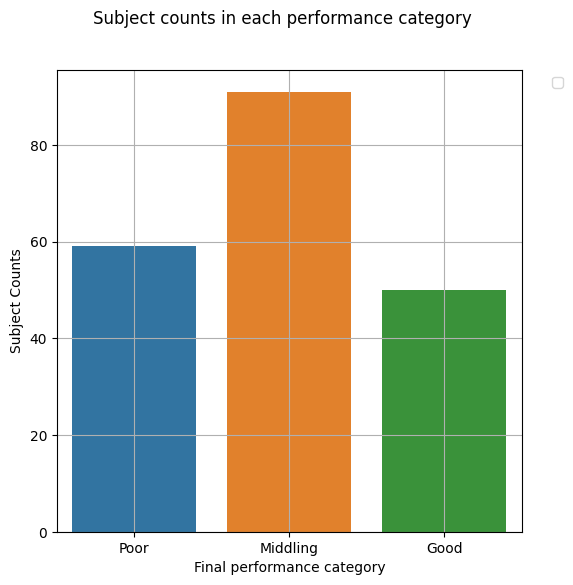

In [31]:

import sys,os
import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.mixture import GaussianMixture

from jax import vmap
import jax.numpy as jnp

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.preprocess import get_preprocessed_data_from_df
from analysis_tools.dataframe_from_raw_data import get_full_dataframe_from_raw_data

LLM_CLASSIFS_PATH = os.path.join("results","llm_classifications","29_01.data")

STUDIES_EXTRACTION_CODES = {
    # "study_1" : {
    #     "dict_code" : "002",
    #     "internal_task_id" : "002",
    #     "studies_id" : None,
    #     "exclude_subjects" : ["5c9cb670b472d0001295f377"],
    #     "feedback_noise_bins" : [0,0.2,0.4,1]
    # },
    "study_2" : {
        "dict_code" : "003_1",
        "internal_task_id" : "003",
        "studies_id" :  ["66f96c31e69227986334a027","66d086503c0a69291c361b67"],
        "exclude_subjects" : ["615c1741d4630b25e6bc1cb9"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    },
    "study_3" : {
        "dict_code" : "003_2",
        "internal_task_id" : "003",
        "studies_id" : ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"],
        "exclude_subjects" : ["611d60c383f4f70ff4bc99fd", "66a74bdfdcaccdc0703894d5",
                              "667d92f2ea5c1542f417285d", "6548f570022275786186ffbd"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    }
}

LAST_T_TIMESTEPS = 5
LAST_K_TRIALS = 3
subjects_df = get_full_dataframe_from_raw_data(STUDIES_EXTRACTION_CODES,LLM_CLASSIFS_PATH,LAST_T_TIMESTEPS,LAST_K_TRIALS)

In [32]:

import sys
import pickle 
import os
print(sys.prefix)
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import jax
import jax.numpy as jnp
from jax import vmap
from jax.tree_util import tree_map
import jax.random as jr
import tensorflow_probability.substrates.jax.distributions as tfd

from functools import partial

import importlib   # To import model files with poorly written names  ¯\_(ツ)_/¯
from tabulate import tabulate # to make pretty tables : 

# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree

# To make nice plots : 
from simulate.plot_trajectory import plot_training

# To extract the data : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from analysis_tools.preprocess import get_preprocessed_data_from_df
from utils import remove_by_indices


# The agent class : 
from simulate.general_agent import Agent

# The simulated environment :
from simulate.generate_observations_full_actions import TrainingEnvironment,simulate_training
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import generate_synthetic_data

# The inversion scripts :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from simulate.invert_model import invert_data_for_single_model,invert_data_for_library_of_models
from simulate.simulate_utils import ind2sub,discretize_normal_pdf

from simulate.plot_trajectory import plot_actions,plot_learnt_transition_matrix,plot_learnt_q_table


RESULTS_SAVEPATH = os.path.join("results","final_inversions_mle")

GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]
    

def simulate_subjs_in_env(sigma_env,sigma_subj,
                          n_points,
                          n_trials= 10,SEED=10000):
    # environment constants :
    T = 11
    NTRIALS = n_trials

    # MODEL CONSTANTS :
    N_LATENT_STATES = 5

    # ENVIRONMENTAL CONSTANTS :
    N_FEEDBACK_OUTCOMES = 30
    TRUE_FEEDBACK_STD = sigma_env
    

    # The weights of the HMM environment
    (a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

    rngkey = jax.random.PRNGKey(np.random.randint(0,10))
    ENVIRONMENT = TrainingEnvironment(a,b,c,d,e,u,T,NTRIALS)
    
    
    # define the static dimensions of the problem :
    No = N_FEEDBACK_OUTCOMES
    Ns = N_LATENT_STATES
    MODEL_CONSTANTS = {
        "position" : {
            "N_actions" : 9,
            "N_outcomes" : No,
            "N_states" : Ns,
            "Th" : 2
        },
        "angle" : {
            "N_actions" : 9,
            "N_outcomes" : No,
            "N_states" : Ns,
            "Th" : 2
        },
        "distance" : {
            "N_actions" : 4,
            "N_outcomes" : No,
            "N_states" : Ns,
            "Th" : 2
        },
    }
    
    
    
    
    model_specs = {
        "model_family" : "aif",  # "rw" / "latql" / "trw"
        "free_parameters" : "mixed",
        "efe_compute_method" : "classic",
        
        "learn_habits" : False,
        "set_initial_transition_confidence" : True,
        "learn_during_trials" :True,
                        
        "biaises" : ['initial'],
        
        "modality_selector" : None,
        
        "generalizer" : {
            "transitions_generalize" : True
        }
    }    
    agent = Agent(model_specs,MODEL_CONSTANTS)  
    model_hyperparameters = {
        'beta_pi' : 50.0,
        
        'habits_learning_rate': 0.0,
        
        'initial_transition_stickiness' : 1.0,
        "initial_transition_confidence" : 1.0,
        
        'transition_learning_rate': 5.0, 
        'transition_forgetting_rate': 0.0,
        
        
        'reward_seeking' : 10.0,
        
        'gamma_generalize' : 0.5,
        
        'perception_sigma' : sigma_subj,
        
        'position':{
            'initial_e' : jnp.ones((9,))  # The center of the screen is favorized initially
        },
        'angle':{
            'initial_e' :  jnp.ones((9,))
        },
        'distance':{
            'initial_e' :  jnp.ones((4,))
        },
    }
     


    static_environment_functions = ENVIRONMENT.get_functions()
    agent_function_getter = lambda x : agent.get_all_functions(x)
    
    def agent_training_function(seed):
        final_parameters,(environment_variables,agent_variables) = simulate_training(static_environment_functions,agent_function_getter(model_hyperparameters),
                    seed,n_trials=NTRIALS,n_observations_per_trial= ENVIRONMENT.T)
        (_env_states,_env_obs,_env_rewards) = environment_variables
        (_agent_states,_new_params,_agent_actions,additionnal_data) = agent_variables
        
        return {"feedback":_env_obs[0],"rewards":_env_rewards, "env_state":_env_states,"actions":_agent_actions}
    
    fullshape = (n_points,)
    keys = jax.random.split(jr.PRNGKey(SEED), num=jnp.prod(jnp.array(fullshape)))  # Flattened keys
    keys = jnp.reshape(keys,fullshape+(2,))
    mapped_vals = jax.vmap(agent_training_function)(keys)

    return mapped_vals


# simulation_results= simulate_subjs_in_env(0.175,100,100)

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env


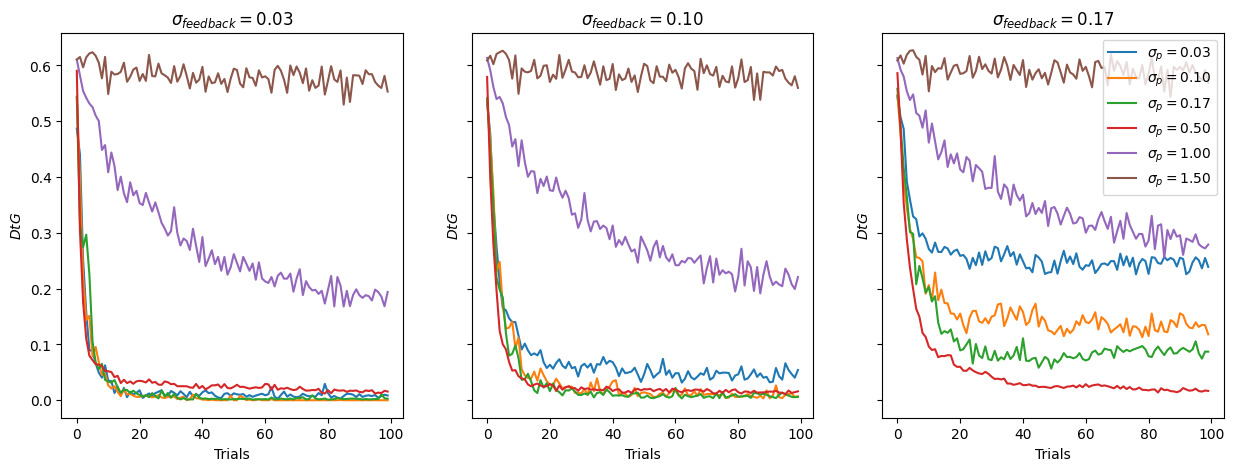

In [33]:

def point_vector_to_dtg(point_vector):
    _true_state_index = jnp.argmax(point_vector,-1)
    _grid_points =  jnp.stack(ind2sub(GRID_SIZE,_true_state_index),axis=-1)
    _maxdist = jnp.linalg.norm(jnp.array(GRID_SIZE))
    _dtgs = jnp.linalg.norm(jnp.array(END_COORD) - _grid_points)/_maxdist
    return _dtgs


n_trials,n_subjs = 100,100


# Plot effect of noise on subject performance for a large number of trials : 
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)

for k,true_fb_std in enumerate([0.025,0.1,0.175]):
    ax = axs[k]
    ax.set_title(r"$\sigma_{feedback} = $" + "{:.2f}".format(true_fb_std))
    ax.set_ylabel("$DtG$")
    ax.set_xlabel("Trials")
    
    for subject_fb_model in [0.025,0.1,0.175,0.5,1.0,1.5]:

        
        simulation_results= simulate_subjs_in_env(true_fb_std,subject_fb_model,
                                                  n_subjs,n_trials)
        true_state_indices = jnp.argmax(jnp.stack(simulation_results["env_state"]),-1)
        dtgs = vmap(vmap(vmap(point_vector_to_dtg)))(simulation_results["env_state"])
        final_perf_sim = np.mean(dtgs[:,:,-LAST_T_TIMESTEPS:],axis=(0,2)).flatten()
        
        ax.plot(np.arange(final_perf_sim.shape[0]),final_perf_sim,label=r"$\sigma_{p} = $" + "{:.2f}".format(subject_fb_model))
    
    if k == 2:
        ax.legend()

(100, 100, 10, 9)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


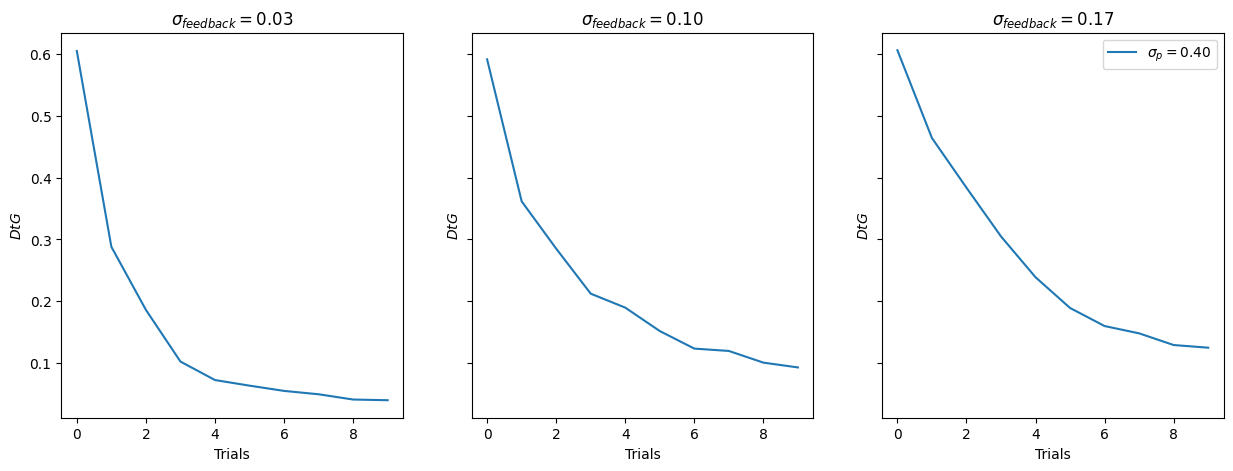

In [34]:
from simulate.simulate_utils import get_points_from_modality_vectors


print(simulation_results["actions"]['angle'].shape)

n_trials,n_subjs = 10,100



simulated_dfs = []


# Plot effect of noise on subject performance for a large number of trials : 
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
for k,true_fb_std in enumerate([0.025,0.1,0.175]):
    ax = axs[k]
    ax.set_title(r"$\sigma_{feedback} = $" + "{:.2f}".format(true_fb_std))
    ax.set_ylabel("$DtG$")
    ax.set_xlabel("Trials")
    
    for subject_fb_model in [0.4]:

        
        simulation_results= simulate_subjs_in_env(true_fb_std,subject_fb_model,
                                                  n_subjs,n_trials)
        true_state_indices = jnp.argmax(jnp.stack(simulation_results["env_state"]),-1)
        dtgs = vmap(vmap(vmap(point_vector_to_dtg)))(simulation_results["env_state"])
        final_perf_sim = np.mean(dtgs[:,:,-LAST_T_TIMESTEPS:],axis=(0,2)).flatten()
        
        ax.plot(np.arange(final_perf_sim.shape[0]),final_perf_sim,label=r"$\sigma_{p} = $" + "{:.2f}".format(subject_fb_model))

        
        simulated_df = pd.DataFrame()
        simulated_df["rewards"] = list(simulation_results["rewards"])
        simulated_df["env_fb_std"] = true_fb_std
        simulated_df["sub_fb_std"] = subject_fb_model
        
        
        Nsubj,Nblocks,Ntrials,_ = simulation_results["actions"]['angle'].shape

        all_points = []
        for subj in range(Nsubj):
            print(subj)
            subj_points = []
            for block in range(Nblocks):
                block_points = []
                for trial in range(Ntrials):           
                    trial_action = {key:val[subj,block,trial,:] for (key,val) in simulation_results["actions"].items()}
                    trial_points = get_points_from_modality_vectors(trial_action)
                    
                    block_points.append(trial_points)
                subj_points.append(block_points)
            all_points.append(subj_points)

        simulated_points = np.array(all_points)
        simulated_df["action_points"] = list(simulated_points)
        
        
        simulated_dfs.append(simulated_df)
    if k == 2:
        ax.legend()
        



# _agent_actions = simulation_results["actions"]
# subj,trial = 0,15

# actions_plotted = {key:val[subj,trial] for (key,val) in _agent_actions.items()}
# print({key:np.argmax(val,axis=-1) for (key,val) in actions_plotted.items()})

# print(simulation_results["actions"]['angle'].shape)

# Nsubj,Nblocks,Ntrials,_ = simulation_results["actions"]['angle'].shape

# all_points = []
# for subj in range(Nsubj):
#     print(subj)
#     subj_points = []
#     for block in range(Nblocks):
#         block_points = []
#         for trial in range(Ntrials):           
#             trial_action = {key:val[subj,block,trial,:] for (key,val) in simulation_results["actions"].items()}
#             trial_points = get_points_from_modality_vectors(trial_action)
            
#             block_points.append(trial_points)
#         subj_points.append(block_points)
#     all_points.append(subj_points)

# simulated_points = np.array(all_points)

In [35]:
# print(simulated_points.shape)
# print(simulation_results["reward"].shape)

# new_df = pd.DataFrame()
# new_df["rewards"] = list(simulation_results["reward"])
# new_df["env_fb_std"] = 0.25

# other_df = pd.DataFrame()
# other_df["rewards"] = list(simulation_results["reward"])
# other_df["env_fb_std"] = 0.025


# print(pd.concat([new_df, df2], ignore_index=True))

simulated_df_full = pd.concat(simulated_dfs,ignore_index=True)
print(np.stack(simulated_df_full['rewards']))

[[[ 0.          0.06896551  0.13793105 ... -0.03448278  0.20689654
    0.10344827]
  [ 0.          0.13793103  0.24137929 ...  0.         -0.03448278
    0.03448278]
  [ 0.          0.20689656  0.10344827 ...  0.          0.
    0.        ]
  ...
  [ 0.          0.06896551  0.20689654 ...  0.          0.
    0.        ]
  [ 0.         -0.03448276  0.1724138  ...  0.          0.
    0.        ]
  [ 0.          0.31034482  0.06896552 ... -0.03448278  0.03448278
    0.        ]]

 [[ 0.          0.03448276 -0.10344827 ...  0.10344827  0.
    0.03448278]
  [ 0.          0.1724138   0.13793102 ...  0.         -0.10344833
    0.06896555]
  [ 0.          0.1724138   0.13793102 ... -0.03448278  0.03448278
    0.03448278]
  ...
  [ 0.          0.20689654  0.13793105 ...  0.          0.
    0.        ]
  [ 0.          0.20689654  0.20689654 ... -0.03448278  0.06896555
   -0.06896555]
  [ 0.          0.20689654  0.17241383 ...  0.03448278  0.
    0.03448272]]

 [[ 0.          0.          0.034482

(300, 10, 11)


C:\Users\annic\AppData\Local\Temp\ipykernel_19120\2407674139.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[label] = list(dnext_act)
C:\Users\annic\AppData\Local\Temp\ipykernel_19120\2407674139.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[label] = list(dnext_act)
C:\Users\annic\AppData\Local\Temp\ipykernel_19120\2407674139.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

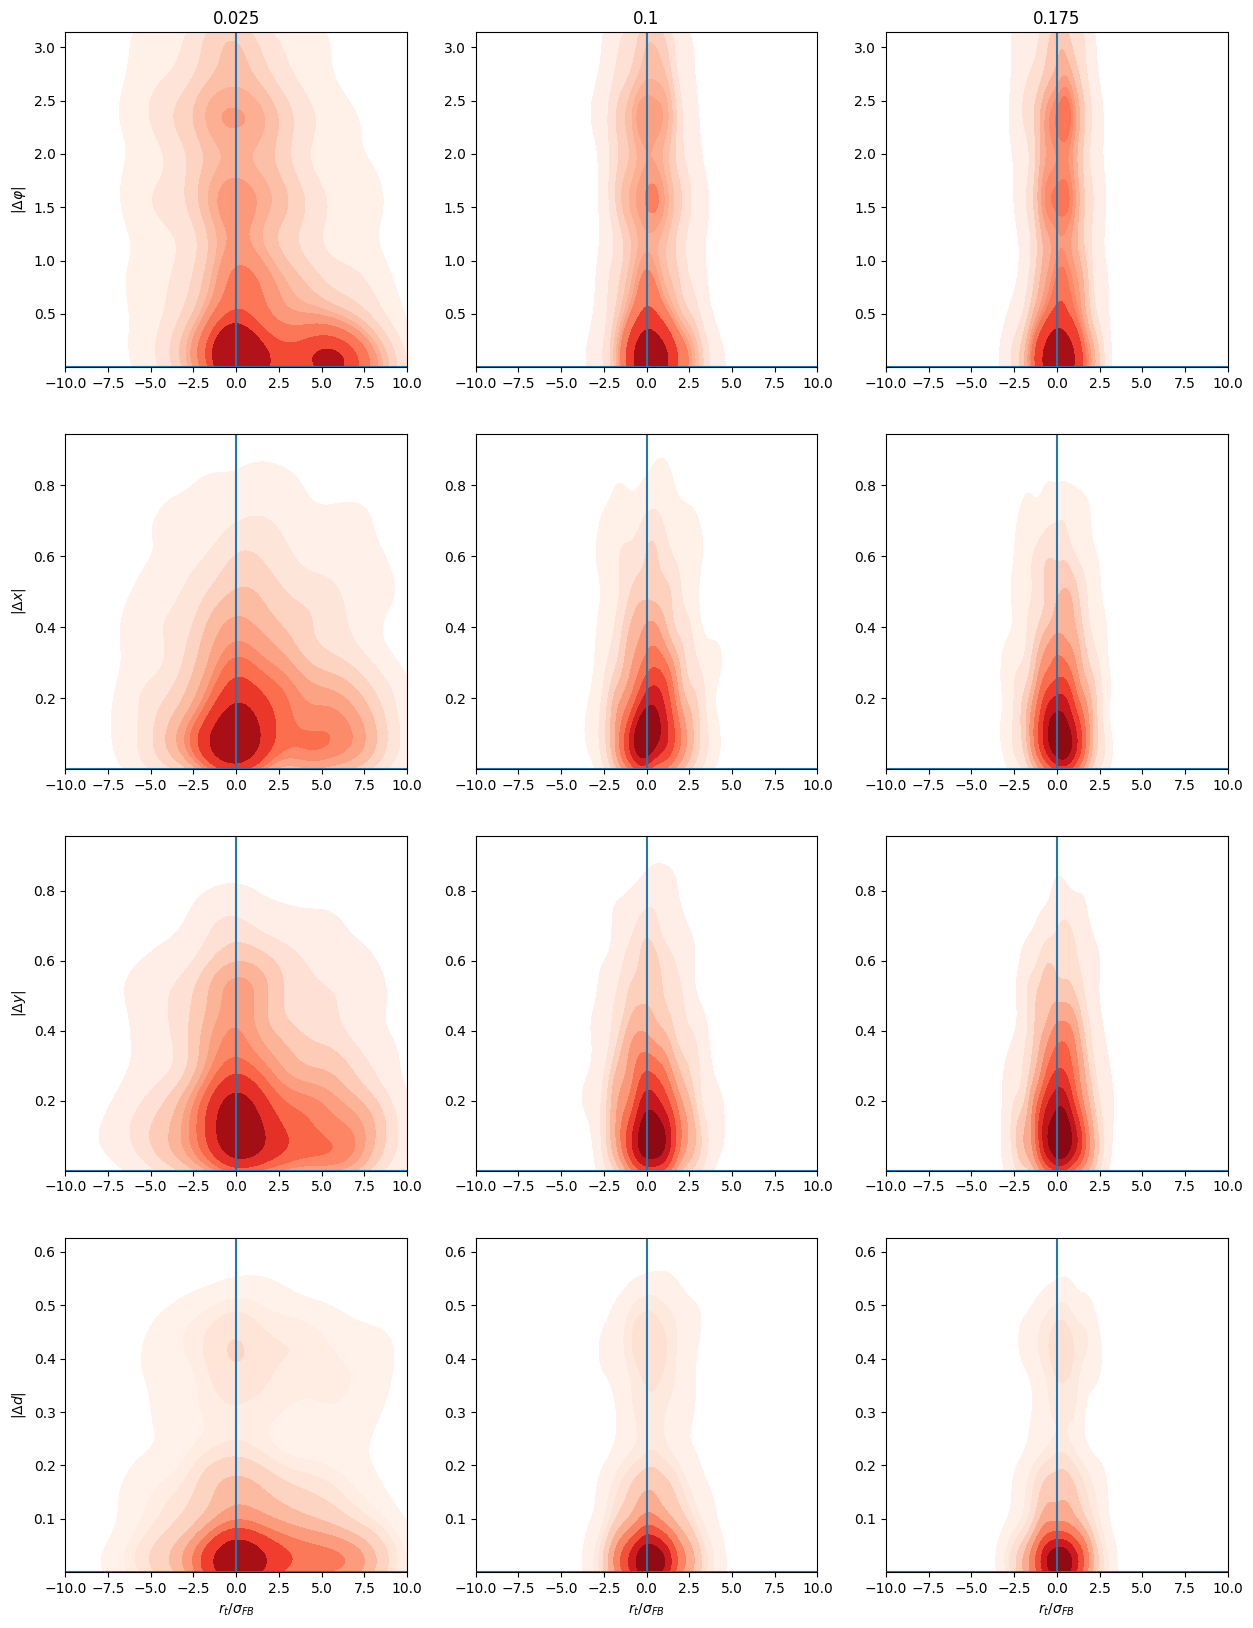

In [36]:
plot_normalized_deltas = True


look_between_a = 0
look_between_b = 2


# Difference between raw points at times t and t+1
points = np.stack(simulated_df_full["action_points"])
Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape



points = np.stack(simulated_df_full['action_points'])

points_1 = points[...,0,:]
points_2 = points[...,1,:]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Encoded barycenters :
barycenter_x = (points_1[...,0] + points_2[...,0])/2.0
barycenter_y = (points_1[...,1] + points_2[...,1])/2.0
all_barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)

# Encoded euclidian distance between points :
all_distances = np.linalg.norm(points_1-points_2,axis=-1)

# Encoded evolution of point angles :
all_angles = np.atan2(points_2[...,1]-points_1[...,1],points_2[...,0]-points_1[...,0])


# Observation data :
delta_gauges = np.stack(simulated_df_full["rewards"])
print(delta_gauges.shape)
positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]

# All diff angles > pi are counted as value -2pi
diff_angle[diff_angle>np.pi] += - 2*np.pi
# All diff angles < -pi are counted as value +2pi
diff_angle[diff_angle< -np.pi] += 2*np.pi

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

label = 'angle'
modality = all_angles   

# for label,modality in zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances]):
#     dgaug = np.reshape(delta_gauges[...,:-1][:,look_between_a:look_between_b],(Nsubj,-1))
#     next_act = np.reshape(modality[:,look_between_a:look_between_b],(Nsubj,-1))
#     print(dgaug.shape)
#     print(next_act.shape)
#     plt.scatter(dgaug,next_act,alpha = 0.1)
#     plt.title("Next {} based on feedback received".format(label))
#     plt.xlabel("Feedback received")
#     plt.ylabel("{} action performed".format(label))
#     plt.show()
    
    
fig,axs = plt.subplots(4,3,figsize=(15,20))

for i,(label,modality,latexlabel) in enumerate(zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances],[r"$ \Delta \varphi $",r"$ \Delta x $",r"$ \Delta y $",r"$ \Delta d $"])):
    dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
    diff = modality[:,:,1:] - modality[:,:,:-1]  # Difference betweeen successive actions 
    
    if label == 'angle':
        # All diff angles > pi are counted as value -2pi
        diff[diff>np.pi] += - 2*np.pi
        # All diff angles < -pi are counted as value +2pi
        diff[diff< -np.pi] += 2*np.pi

    
    dnext_act = np.abs(np.reshape(diff[:,look_between_a:look_between_b],(Nsubj,-1)))
    
    plot_df = simulated_df_full[["env_fb_std","sub_fb_std"]]
    plot_df[label] = list(dnext_act)
    plot_df["delta_gauges"] = list(dgaug)
    exploded_df = plot_df.explode([label, 'delta_gauges'])
    exploded_df['delta_gauges_norm'] = exploded_df['delta_gauges'] / exploded_df["env_fb_std"]
    
    for ax in axs[i,:]:
        ax.set_xlim([-10,10])
        ax.set_ylim([np.min(exploded_df[label]),np.max(exploded_df[label])])
    
    fbs_noises = [0.025,0.1 ,0.175]
    for k,fb_std in enumerate(fbs_noises):
        ax = axs[i,k]
        if i == 0:
            ax.set_title(fb_std)
        
        
        
        ax.axvline(0)
        ax.axhline(0)
        
        
        if plot_normalized_deltas : 
            sns.kdeplot(ax=ax,data = exploded_df[exploded_df['env_fb_std']==fb_std],x = "delta_gauges_norm",y=label, cmap='Reds',fill=True)
        else : 
            sns.kdeplot(ax=ax,data = exploded_df[exploded_df['env_fb_std']==fb_std],x = "delta_gauges",y=label, cmap='Reds',fill=True)
        if k == 0:
            ax.set_ylabel("|"+ latexlabel + "|")
        else : 
            ax.set_ylabel("")
        if i == 3 :
            if plot_normalized_deltas : 
                ax.set_xlabel("$r_t / \sigma_{FB}$")
            else:
                ax.set_xlabel("$r_t$")
        else : 
            ax.set_xlabel("")
            
plt.show()

The exploration / exploitation shift is clearly visible in the last category of subjects, with a distinct decrease in the average variation in point position. This is far less visible in less successful subject categories.

Question : for a single action modality, how does the intensity of a variation relate to the variation of the other modalities.

C:\Users\annic\AppData\Local\Temp\ipykernel_19120\3549487543.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[label] = list(dnext_act)
C:\Users\annic\AppData\Local\Temp\ipykernel_19120\3549487543.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["delta_gauges"] = list(dgaug)
C:\Users\annic\AppData\Local\Temp\ipykernel_19120\3549487543.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

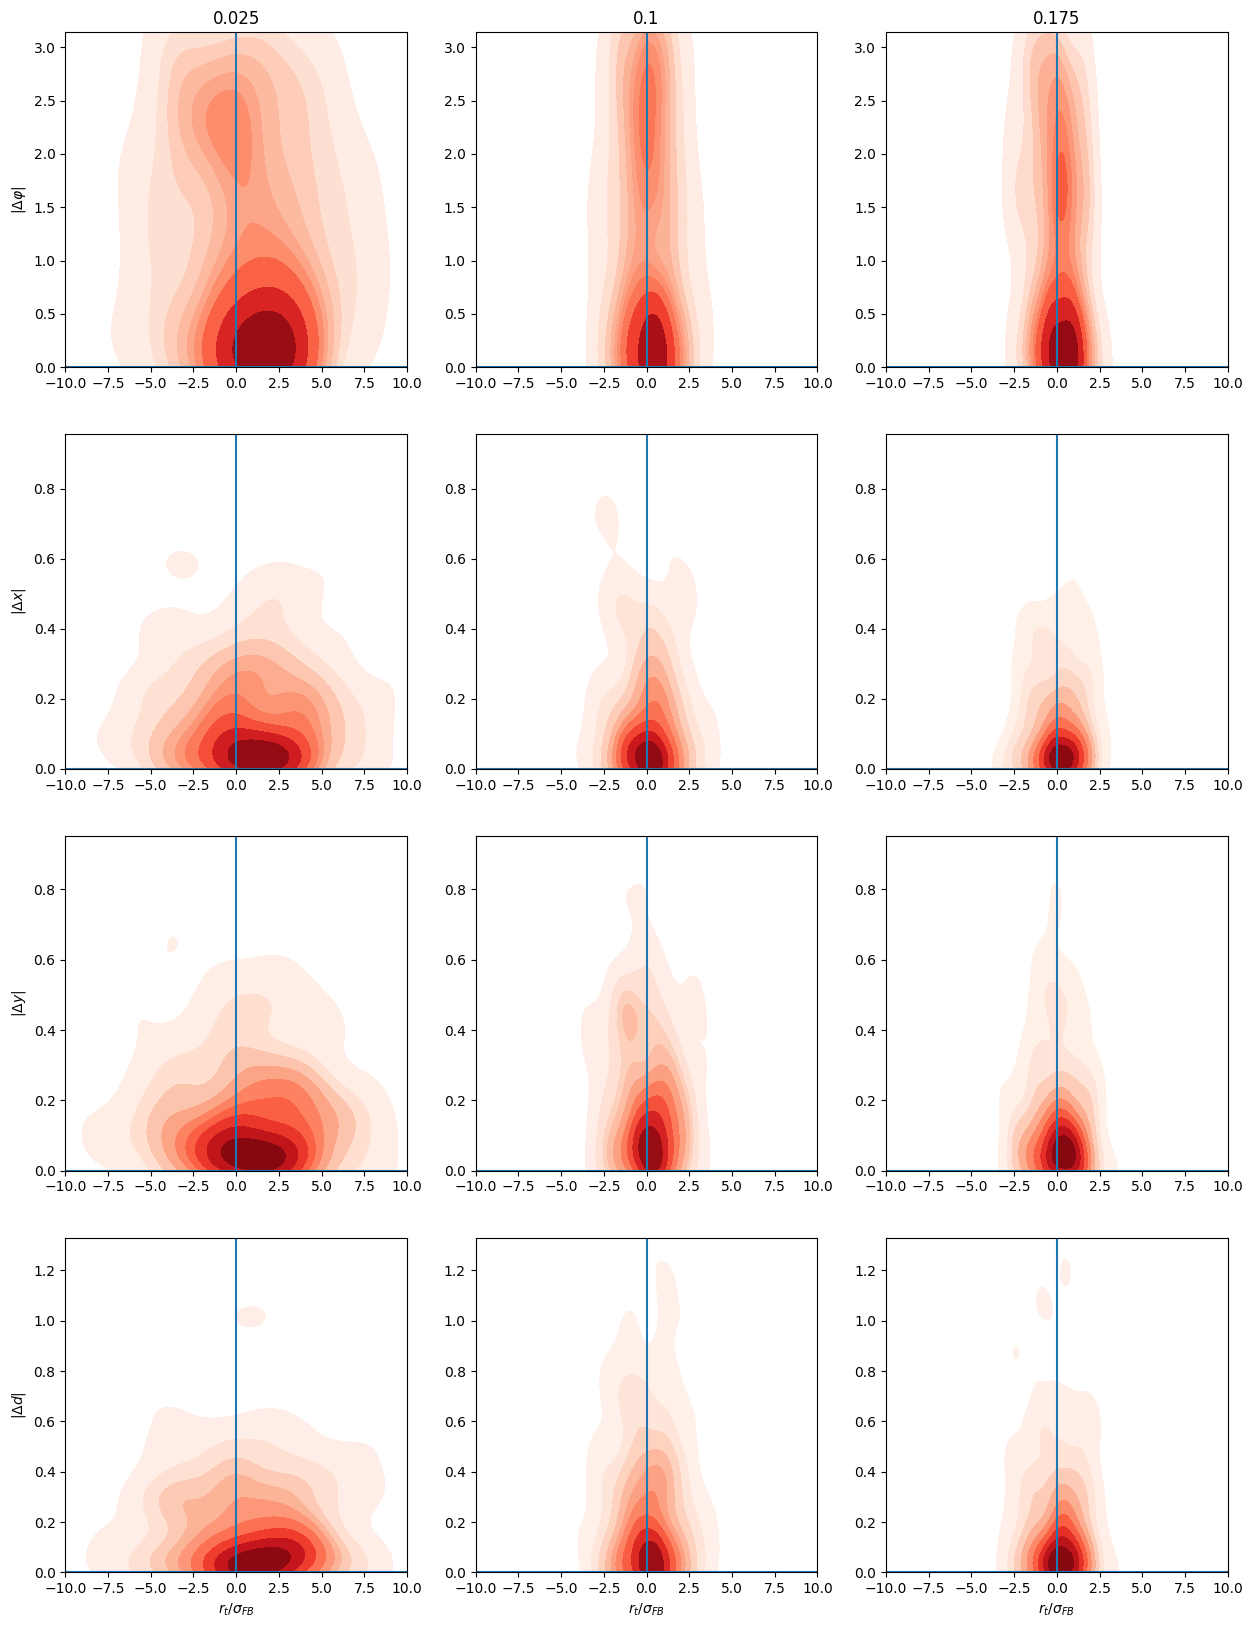

In [51]:
copy_df = subjects_df[subjects_df["study_name"]=="study_3"]

plot_normalized_deltas = True


look_between_a = 0
look_between_b = 2


# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])
Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Observations : 
list_of_subjects_rtf = list(copy_df["realtime_values"])
all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
    list_of_last_fb = []
    list_of_deltas = []
    for trial_series in _subj_feedback_series:
        trial_last_fbs = []
        trial_delta_fbs = []
        for timestep_series in trial_series:
            initial_feedback_value = timestep_series[0][...,1]
            final_feedback_value = timestep_series[-1][...,1]
            
            # print(timestep_series[0,:])
            
            trial_last_fbs.append(final_feedback_value)
            
            delta_feedback = final_feedback_value - initial_feedback_value
            trial_delta_fbs.append(delta_feedback)
                
        list_of_last_fb.append(trial_last_fbs)
        list_of_deltas.append(trial_delta_fbs)
    
    all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
    all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))

# Action data :
all_barycenters = np.stack(copy_df["action_barycenters"],axis=0)
all_angles = np.stack(copy_df["action_angles"],axis=0)
all_distances = np.stack(copy_df["action_distances"],axis=0)
all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# Observation data :
gauge_levels = np.array(all_subject_obs["gauge_level"])
delta_gauges = np.array(all_subject_obs["delta_gauge"])

positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]

# All diff angles > pi are counted as value -2pi
diff_angle[diff_angle>np.pi] += - 2*np.pi
# All diff angles < -pi are counted as value +2pi
diff_angle[diff_angle< -np.pi] += 2*np.pi

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

label = 'angle'
modality = all_angles   

# for label,modality in zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances]):
#     dgaug = np.reshape(delta_gauges[...,:-1][:,look_between_a:look_between_b],(Nsubj,-1))
#     next_act = np.reshape(modality[:,look_between_a:look_between_b],(Nsubj,-1))
#     print(dgaug.shape)
#     print(next_act.shape)
#     plt.scatter(dgaug,next_act,alpha = 0.1)
#     plt.title("Next {} based on feedback received".format(label))
#     plt.xlabel("Feedback received")
#     plt.ylabel("{} action performed".format(label))
#     plt.show()
    
    
fig,axs = plt.subplots(4,3,figsize=(15,20))

for i,(label,modality,latexlabel) in enumerate(zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances],[r"$ \Delta \varphi $",r"$ \Delta x $",r"$ \Delta y $",r"$ \Delta d $"])):
    dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
    diff = modality[:,:,1:] - modality[:,:,:-1]  # Difference betweeen successive actions 
    
    if label == 'angle':
        # All diff angles > pi are counted as value -2pi
        diff[diff>np.pi] += - 2*np.pi
        # All diff angles < -pi are counted as value +2pi
        diff[diff< -np.pi] += 2*np.pi

    
    dnext_act = np.abs(np.reshape(diff[:,look_between_a:look_between_b],(Nsubj,-1)))
    
    plot_df = copy_df[["subject_id","final_performance","feedback_noise_std","performance_category"]]
        
    plot_df[label] = list(dnext_act)
    plot_df["delta_gauges"] = list(dgaug)
    
    plot_df = plot_df[plot_df["performance_category"]=="Poor"]
    exploded_df = plot_df.explode([label, 'delta_gauges'])
    exploded_df['delta_gauges_norm'] = exploded_df['delta_gauges'] / exploded_df["feedback_noise_std"]
    
    for ax in axs[i,:]:
        ax.set_xlim([-10,10])
        ax.set_ylim([np.min(exploded_df[label]),np.max(exploded_df[label])])
    
    fbs_noises = [0.025,0.1 ,0.175]
    for k,fb_std in enumerate(fbs_noises):
        ax = axs[i,k]
        if i == 0:
            ax.set_title(fb_std)
        
        
        
        ax.axvline(0)
        ax.axhline(0)
        
        
        if plot_normalized_deltas : 
            sns.kdeplot(ax=ax,data = exploded_df[exploded_df['feedback_noise_std']==fb_std],x = "delta_gauges_norm",y=label, cmap='Reds',fill=True)
        else : 
            sns.kdeplot(ax=ax,data = exploded_df[exploded_df['feedback_noise_std']==fb_std],x = "delta_gauges",y=label, cmap='Reds',fill=True)
        if k == 0:
            ax.set_ylabel("|"+ latexlabel + "|")
        else : 
            ax.set_ylabel("")
        if i == 3 :
            if plot_normalized_deltas : 
                ax.set_xlabel("$r_t / \sigma_{FB}$")
            else:
                ax.set_xlabel("$r_t$")
        else : 
            ax.set_xlabel("")
            
plt.show()

(300, 10, 11)


C:\Users\annic\AppData\Local\Temp\ipykernel_19120\2614283114.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[label] = list(dnext_act)
C:\Users\annic\AppData\Local\Temp\ipykernel_19120\2614283114.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[label] = list(dnext_act)
C:\Users\annic\AppData\Local\Temp\ipykernel_19120\2614283114.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

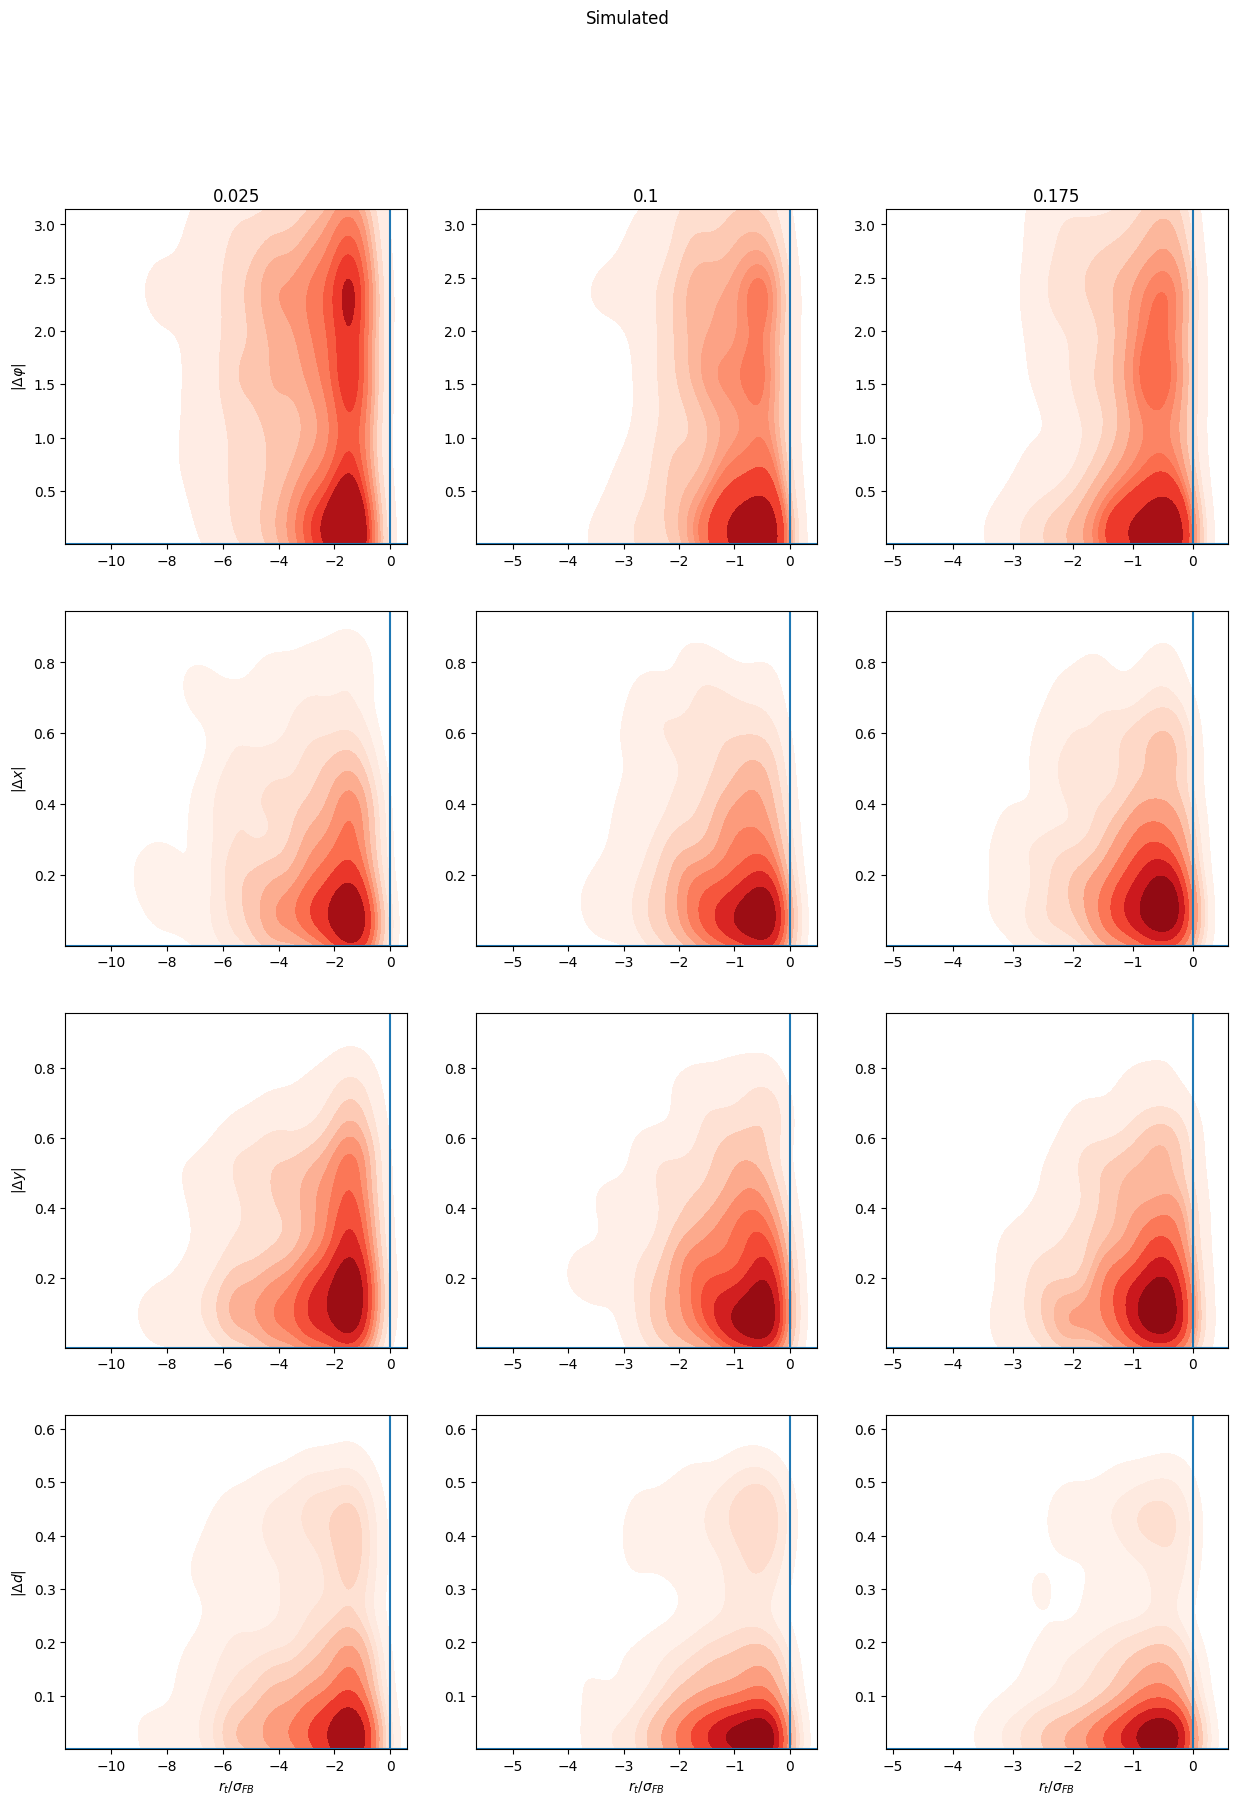

In [42]:
plot_normalized_deltas = True


look_between_a = 0
look_between_b = 2


# Difference between raw points at times t and t+1
points = np.stack(simulated_df_full["action_points"])
Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape



points = np.stack(simulated_df_full['action_points'])

points_1 = points[...,0,:]
points_2 = points[...,1,:]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Encoded barycenters :
barycenter_x = (points_1[...,0] + points_2[...,0])/2.0
barycenter_y = (points_1[...,1] + points_2[...,1])/2.0
all_barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)

# Encoded euclidian distance between points :
all_distances = np.linalg.norm(points_1-points_2,axis=-1)

# Encoded evolution of point angles :
all_angles = np.atan2(points_2[...,1]-points_1[...,1],points_2[...,0]-points_1[...,0])


# Observation data :
delta_gauges = np.stack(simulated_df_full["rewards"])
print(delta_gauges.shape)
positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]

# All diff angles > pi are counted as value -2pi
diff_angle[diff_angle>np.pi] += - 2*np.pi
# All diff angles < -pi are counted as value +2pi
diff_angle[diff_angle< -np.pi] += 2*np.pi

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

label = 'angle'
modality = all_angles   

# for label,modality in zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances]):
#     dgaug = np.reshape(delta_gauges[...,:-1][:,look_between_a:look_between_b],(Nsubj,-1))
#     next_act = np.reshape(modality[:,look_between_a:look_between_b],(Nsubj,-1))
#     print(dgaug.shape)
#     print(next_act.shape)
#     plt.scatter(dgaug,next_act,alpha = 0.1)
#     plt.title("Next {} based on feedback received".format(label))
#     plt.xlabel("Feedback received")
#     plt.ylabel("{} action performed".format(label))
#     plt.show()
    
    
fig,axs = plt.subplots(4,3,figsize=(15,20))
fig.suptitle("Simulated")
for i,(label,modality,latexlabel) in enumerate(zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances],[r"$ \Delta \varphi $",r"$ \Delta x $",r"$ \Delta y $",r"$ \Delta d $"])):
    dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
    diff = modality[:,:,1:] - modality[:,:,:-1]  # Difference betweeen successive actions 
    
    if label == 'angle':
        # All diff angles > pi are counted as value -2pi
        diff[diff>np.pi] += - 2*np.pi
        # All diff angles < -pi are counted as value +2pi
        diff[diff< -np.pi] += 2*np.pi

    
    dnext_act = np.abs(np.reshape(diff[:,look_between_a:look_between_b],(Nsubj,-1)))
    
    plot_df = simulated_df_full[["env_fb_std","sub_fb_std"]]
    plot_df[label] = list(dnext_act)
    plot_df["delta_gauges"] = list(dgaug)
    exploded_df = plot_df.explode([label, 'delta_gauges'])
    exploded_df['delta_gauges_norm'] = exploded_df['delta_gauges'] / exploded_df["env_fb_std"]
    
    for ax in axs[i,:]:
        # ax.set_xlim([-10,10])
        ax.set_ylim([np.min(exploded_df[label]),np.max(exploded_df[label])])
    
    fbs_noises = [0.025,0.1 ,0.175]
    for k,fb_std in enumerate(fbs_noises):
        ax = axs[i,k]
        if i == 0:
            ax.set_title(fb_std)
        
        
        
        ax.axvline(0)
        ax.axhline(0)
        
        
        if plot_normalized_deltas : 
            sns.kdeplot(ax=ax,data = exploded_df[(exploded_df['env_fb_std']==fb_std)&(exploded_df['delta_gauges']<0)],x = "delta_gauges_norm",y=label, cmap='Reds',fill=True)
        else : 
            sns.kdeplot(ax=ax,data = exploded_df[(exploded_df['env_fb_std']==fb_std)&(exploded_df['delta_gauges']<0)],x = "delta_gauges",y=label, cmap='Reds',fill=True)
        if k == 0:
            ax.set_ylabel("|"+ latexlabel + "|")
        else : 
            ax.set_ylabel("")
        if i == 3 :
            if plot_normalized_deltas : 
                ax.set_xlabel("$r_t / \sigma_{FB}$")
            else:
                ax.set_xlabel("$r_t$")
        else : 
            ax.set_xlabel("")
            
plt.show()

C:\Users\annic\AppData\Local\Temp\ipykernel_19120\3103737289.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[label] = list(dnext_act)
C:\Users\annic\AppData\Local\Temp\ipykernel_19120\3103737289.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["delta_gauges"] = list(dgaug)
C:\Users\annic\AppData\Local\Temp\ipykernel_19120\3103737289.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

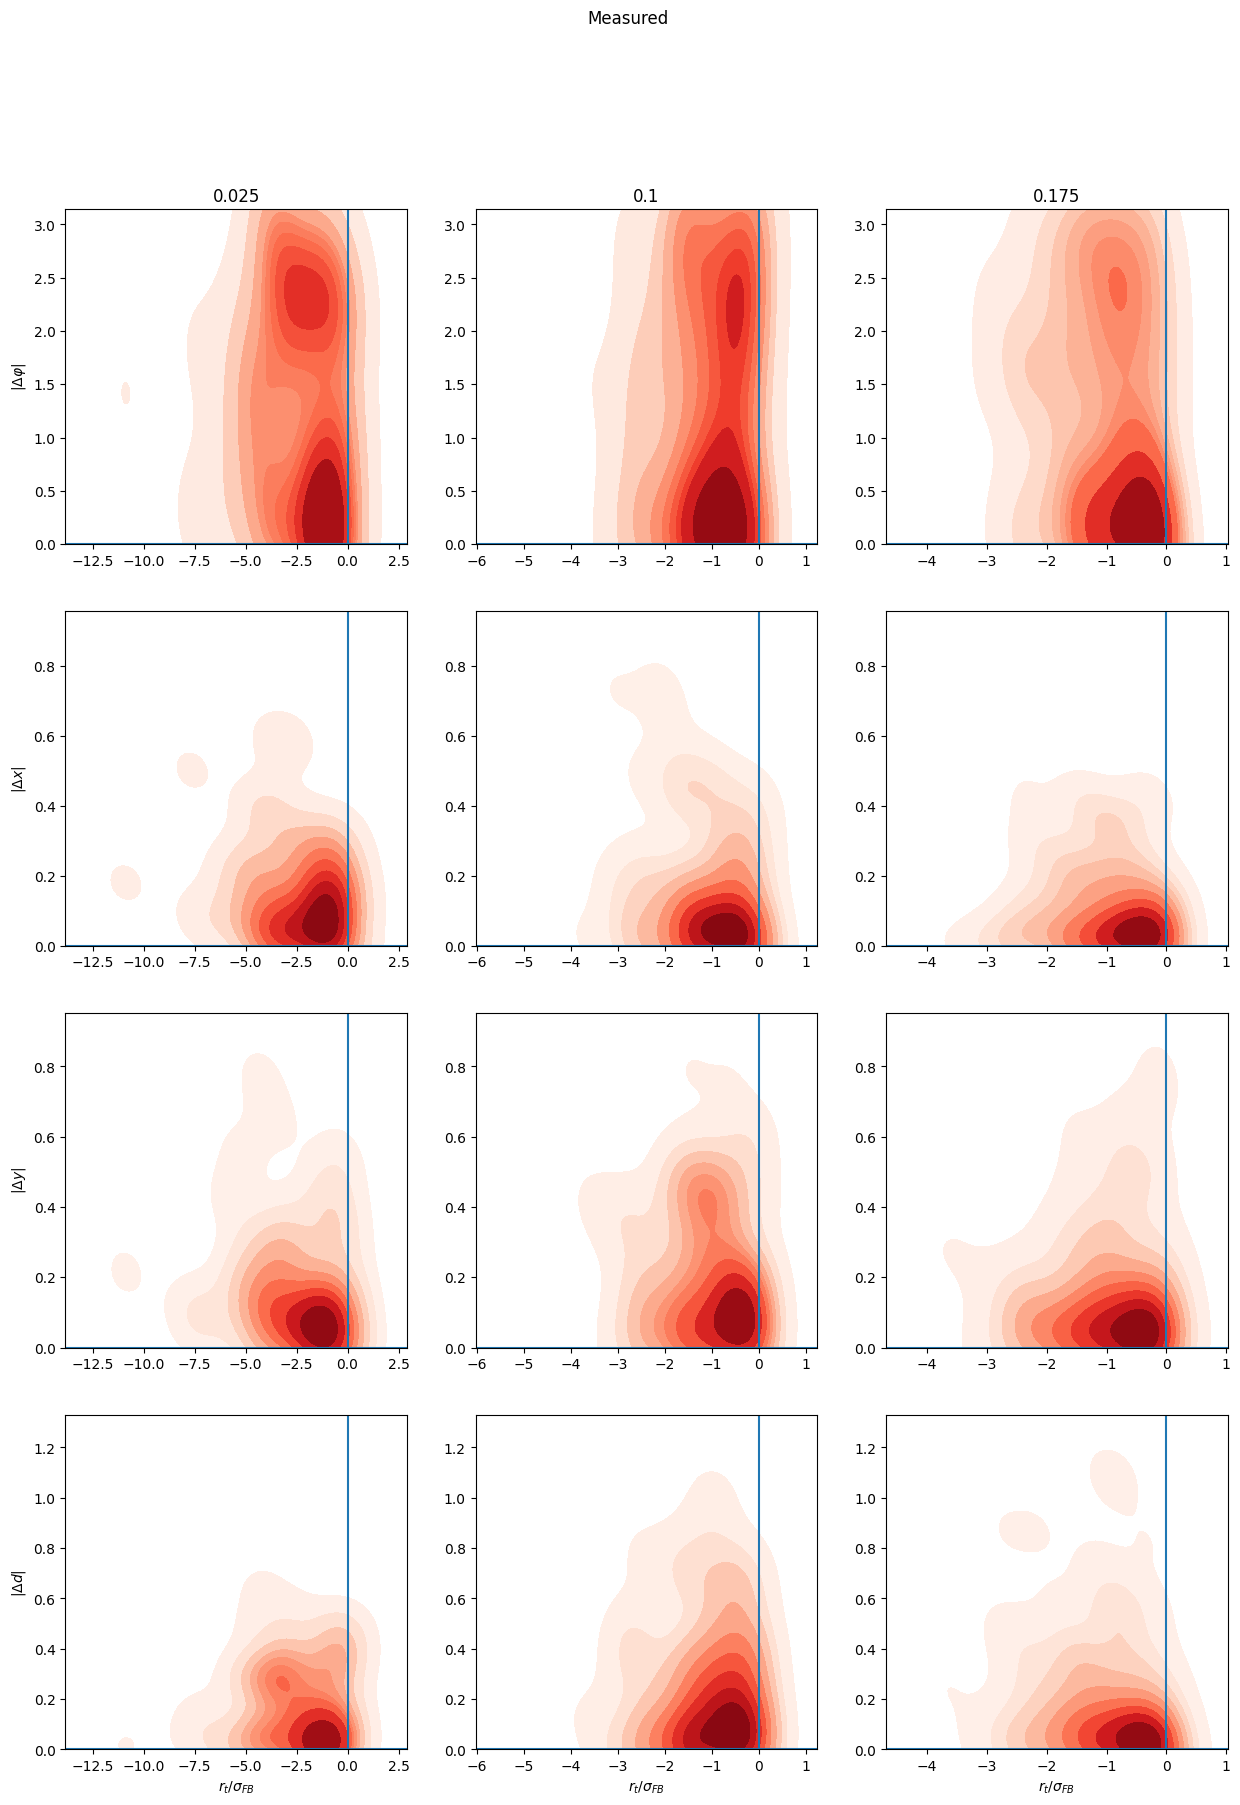

In [50]:
copy_df = subjects_df[subjects_df["study_name"]=="study_3"]

plot_normalized_deltas = True


look_between_a = 0
look_between_b = 2


# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])
Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Observations : 
list_of_subjects_rtf = list(copy_df["realtime_values"])
all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
    list_of_last_fb = []
    list_of_deltas = []
    for trial_series in _subj_feedback_series:
        trial_last_fbs = []
        trial_delta_fbs = []
        for timestep_series in trial_series:
            initial_feedback_value = timestep_series[0][...,1]
            final_feedback_value = timestep_series[-1][...,1]
            
            # print(timestep_series[0,:])
            
            trial_last_fbs.append(final_feedback_value)
            
            delta_feedback = final_feedback_value - initial_feedback_value
            trial_delta_fbs.append(delta_feedback)
                
        list_of_last_fb.append(trial_last_fbs)
        list_of_deltas.append(trial_delta_fbs)
    
    all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
    all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))

# Action data :
all_barycenters = np.stack(copy_df["action_barycenters"],axis=0)
all_angles = np.stack(copy_df["action_angles"],axis=0)
all_distances = np.stack(copy_df["action_distances"],axis=0)
all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# Observation data :
gauge_levels = np.array(all_subject_obs["gauge_level"])
delta_gauges = np.array(all_subject_obs["delta_gauge"])

positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]

# All diff angles > pi are counted as value -2pi
diff_angle[diff_angle>np.pi] += - 2*np.pi
# All diff angles < -pi are counted as value +2pi
diff_angle[diff_angle< -np.pi] += 2*np.pi

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

label = 'angle'
modality = all_angles   

# for label,modality in zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances]):
#     dgaug = np.reshape(delta_gauges[...,:-1][:,look_between_a:look_between_b],(Nsubj,-1))
#     next_act = np.reshape(modality[:,look_between_a:look_between_b],(Nsubj,-1))
#     print(dgaug.shape)
#     print(next_act.shape)
#     plt.scatter(dgaug,next_act,alpha = 0.1)
#     plt.title("Next {} based on feedback received".format(label))
#     plt.xlabel("Feedback received")
#     plt.ylabel("{} action performed".format(label))
#     plt.show()
    
    
fig,axs = plt.subplots(4,3,figsize=(15,20))
fig.suptitle("Measured")
for i,(label,modality,latexlabel) in enumerate(zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances],[r"$ \Delta \varphi $",r"$ \Delta x $",r"$ \Delta y $",r"$ \Delta d $"])):
    dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
    diff = modality[:,:,1:] - modality[:,:,:-1]  # Difference betweeen successive actions 
    
    if label == 'angle':
        # All diff angles > pi are counted as value -2pi
        diff[diff>np.pi] += - 2*np.pi
        # All diff angles < -pi are counted as value +2pi
        diff[diff< -np.pi] += 2*np.pi

    
    dnext_act = np.abs(np.reshape(diff[:,look_between_a:look_between_b],(Nsubj,-1)))
    
    plot_df = copy_df[["subject_id","final_performance","feedback_noise_std","performance_category"]]
    plot_df[label] = list(dnext_act)
    plot_df["delta_gauges"] = list(dgaug)
    
    
    plot_df = plot_df[plot_df["performance_category"]=="Poor"]
    exploded_df = plot_df.explode([label, 'delta_gauges'])
    exploded_df['delta_gauges_norm'] = exploded_df['delta_gauges'] / exploded_df["feedback_noise_std"]
    
    for ax in axs[i,:]:
        ax.set_ylim([np.min(exploded_df[label]),np.max(exploded_df[label])])
    
    fbs_noises = [0.025,0.1 ,0.175]
    for k,fb_std in enumerate(fbs_noises):
        ax = axs[i,k]
        if i == 0:
            ax.set_title(fb_std)
        
        
        
        ax.axvline(0)
        ax.axhline(0)
        
        
        if plot_normalized_deltas : 
            sns.kdeplot(ax=ax,data = exploded_df[(exploded_df['feedback_noise_std']==fb_std)&(exploded_df['delta_gauges']<0)],x = "delta_gauges_norm",y=label, cmap='Reds',fill=True)
        else : 
            sns.kdeplot(ax=ax,data = exploded_df[(exploded_df['feedback_noise_std']==fb_std)&(exploded_df['delta_gauges']<0)],x = "delta_gauges",y=label, cmap='Reds',fill=True)
        if k == 0:
            ax.set_ylabel("|"+ latexlabel + "|")
        else : 
            ax.set_ylabel("")
        if i == 3 :
            if plot_normalized_deltas : 
                ax.set_xlabel("$r_t / \sigma_{FB}$")
            else:
                ax.set_xlabel("$r_t$")
        else : 
            ax.set_xlabel("")
            
plt.show()

C:\Users\annic\AppData\Local\Temp\ipykernel_19120\498777772.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["delta_gauges"] = list(dgaug)
C:\Users\annic\AppData\Local\Temp\ipykernel_19120\498777772.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf["delta_gauges"] = edf["delta_gauges"].astype(float)
C:\Users\annic\AppData\Local\Temp\ipykernel_19120\498777772.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

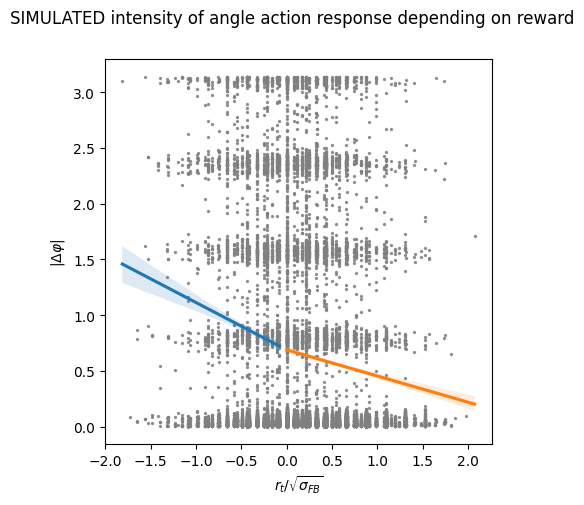

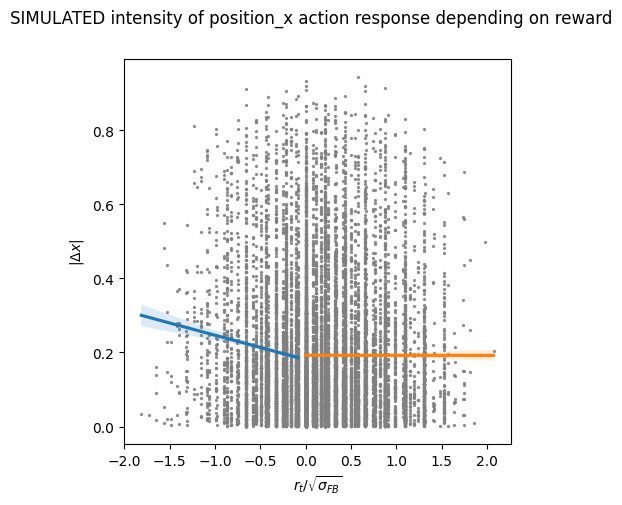

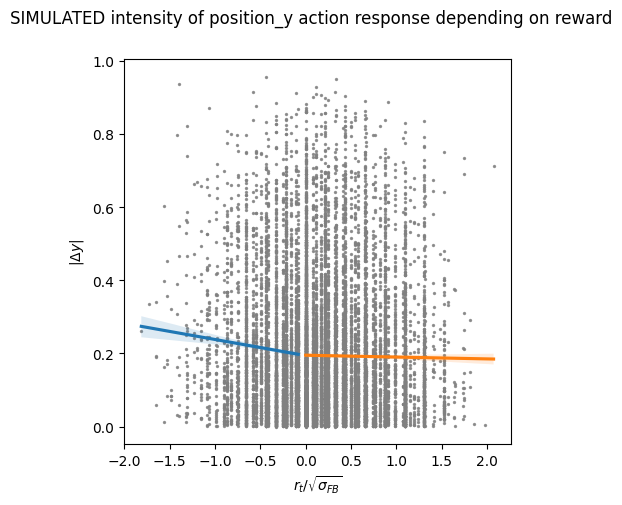

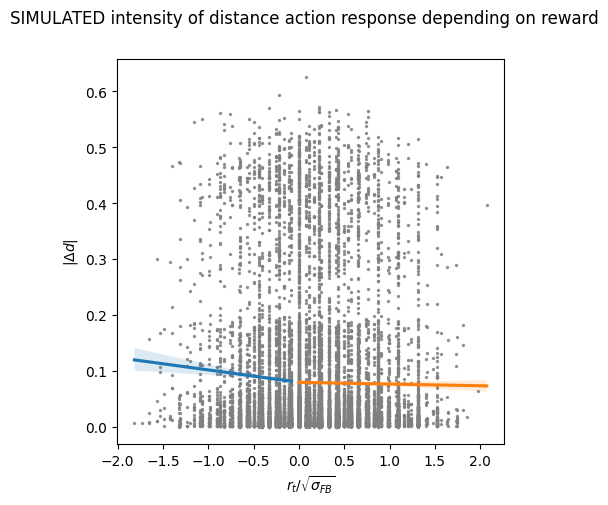

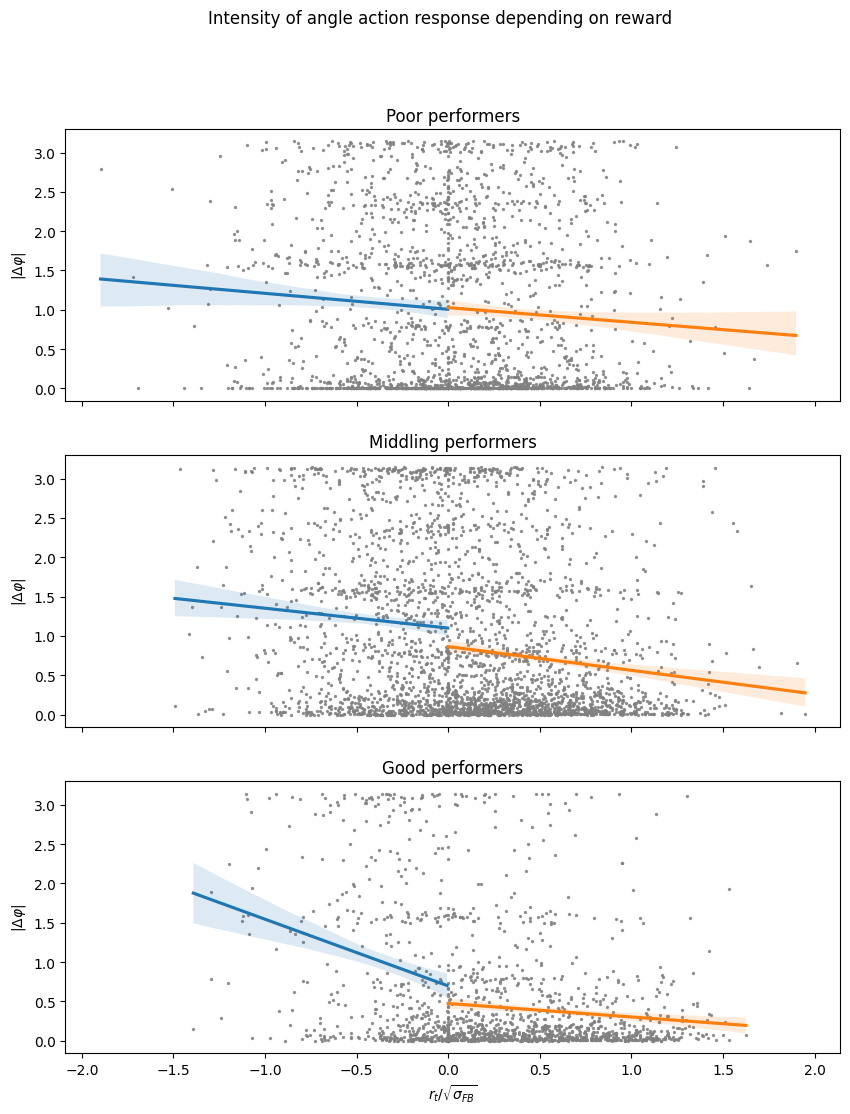

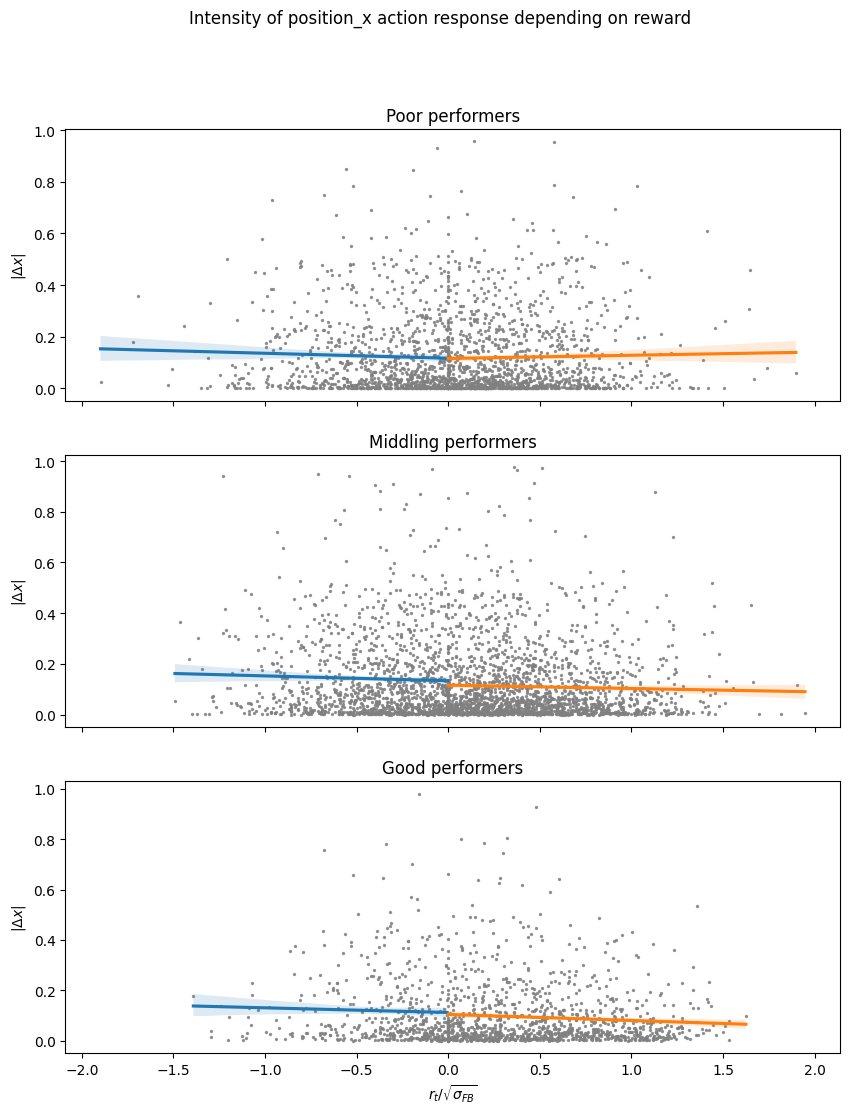

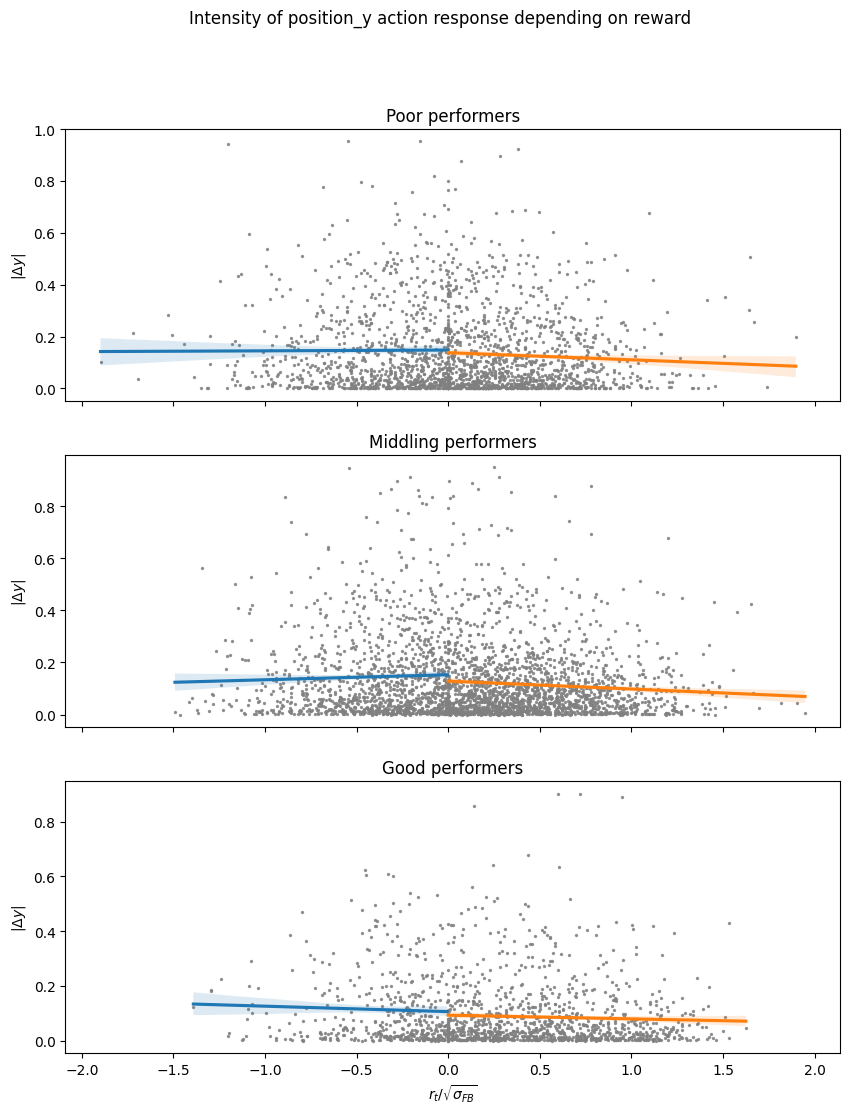

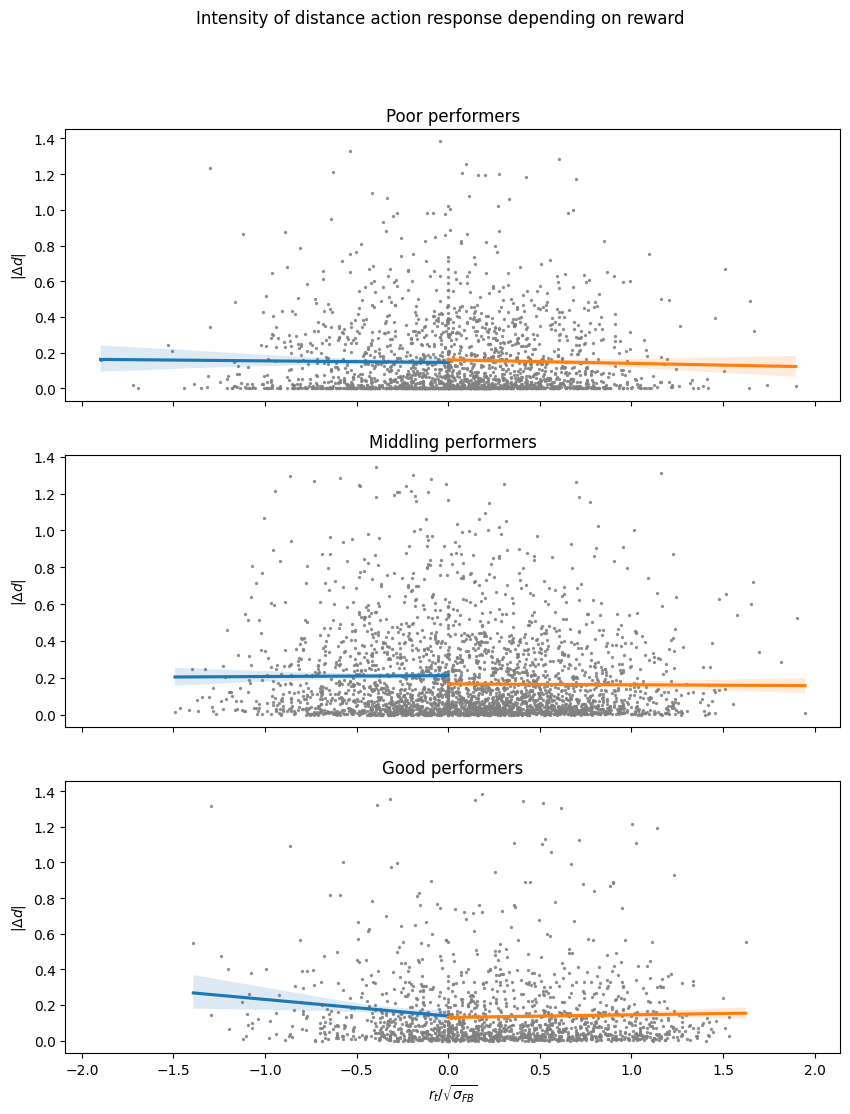

In [59]:
import statsmodels.formula.api as smf
import statsmodels.api as sm 

from scipy import stats
from statsmodels import graphics

plot_normalized_deltas = True


look_between_a = 0
look_between_b = 5


# Difference between raw points at times t and t+1
points = np.stack(simulated_df_full["action_points"])
Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape



points = np.stack(simulated_df_full['action_points'])

points_1 = points[...,0,:]
points_2 = points[...,1,:]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Encoded barycenters :
barycenter_x = (points_1[...,0] + points_2[...,0])/2.0
barycenter_y = (points_1[...,1] + points_2[...,1])/2.0
all_barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)

# Encoded euclidian distance between points :
all_distances = np.linalg.norm(points_1-points_2,axis=-1)

# Encoded evolution of point angles :
all_angles = np.atan2(points_2[...,1]-points_1[...,1],points_2[...,0]-points_1[...,0])


# Observation data :
delta_gauges = np.stack(simulated_df_full["rewards"])


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]

# All diff angles > pi are counted as value -2pi
diff_angle[diff_angle>np.pi] += - 2*np.pi
# All diff angles < -pi are counted as value +2pi
diff_angle[diff_angle< -np.pi] += 2*np.pi

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

label = 'angle'
modality = all_angles   

    
# fig,axs = plt.subplots(4,3,figsize=(15,20))
# fig.suptitle("Simulated")
# for i,(label,modality,latexlabel) in enumerate(zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances],[r"$ \Delta \varphi $",r"$ \Delta x $",r"$ \Delta y $",r"$ \Delta d $"])):
#     dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
#     diff = modality[:,:,1:] - modality[:,:,:-1]  # Difference betweeen successive actions 
    
#     if label == 'angle':
#         # All diff angles > pi are counted as value -2pi
#         diff[diff>np.pi] += - 2*np.pi
#         # All diff angles < -pi are counted as value +2pi
#         diff[diff< -np.pi] += 2*np.pi

    
#     dnext_act = np.abs(np.reshape(diff[:,look_between_a:look_between_b],(Nsubj,-1)))
    
#     plot_df = simulated_df_full[["env_fb_std","sub_fb_std"]]
#     plot_df[label] = list(dnext_act)
#     plot_df["delta_gauges"] = list(dgaug)
#     exploded_df = plot_df.explode([label, 'delta_gauges'])
#     exploded_df['delta_gauges_norm'] = exploded_df['delta_gauges'] / exploded_df["env_fb_std"]

for i,(label,modality,latexlabel) in enumerate(zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances],[r"$ \Delta \varphi $",r"$ \Delta x $",r"$ \Delta y $",r"$ \Delta d $"])):
    diff = modality[:,:,1:] - modality[:,:,:-1]  # Difference betweeen successive actions
    dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
    if label == 'angle':
            diff[diff>np.pi] += - 2*np.pi
            diff[diff< -np.pi] += 2*np.pi
    dnext_act = np.abs(np.reshape(diff[:,look_between_a:look_between_b],(Nsubj,-1)))
    plot_df = simulated_df_full[["env_fb_std","sub_fb_std"]]

    plot_df["delta_gauges"] = list(dgaug)
    plot_df[label] = list(dnext_act)

    exploded_df = plot_df.explode([label, 'delta_gauges'])

    exploded_df_positive = exploded_df[exploded_df["delta_gauges"]>=0]
    exploded_df_negative = exploded_df[exploded_df["delta_gauges"]<0]

    for edf in [exploded_df_positive,exploded_df_negative]:
        edf["delta_gauges"] = edf["delta_gauges"].astype(float)
        edf['delta_gauges_norm'] = edf['delta_gauges'] / np.sqrt(edf["env_fb_std"])
        
        edf[label] = edf[label].astype(float)


    fig,ax =  plt.subplots(1,1,figsize= (5,5),sharex=True)
    fig.suptitle("SIMULATED intensity of {} action response depending on reward".format(label))
    
    
    sns.regplot(ax=ax,data = exploded_df_negative,x="delta_gauges_norm",y=label,scatter_kws={"color": "grey", "s": 2})
    sns.regplot(ax=ax,data = exploded_df_positive,x="delta_gauges_norm",y=label,scatter_kws={"color": "grey", "s": 2})
    ax.set_xlabel("$r_t/\sqrt{\sigma_{FB}}$")
    # ax.set_ylabel(r"$| \Delta \varphi|$")
    ax.set_ylabel("|"+ latexlabel + "|")
        




copy_df = subjects_df[subjects_df["study_name"]=="study_3"]



# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])
Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Observations : 
list_of_subjects_rtf = list(copy_df["realtime_values"])
all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
    list_of_last_fb = []
    list_of_deltas = []
    for trial_series in _subj_feedback_series:
        trial_last_fbs = []
        trial_delta_fbs = []
        for timestep_series in trial_series:
            initial_feedback_value = timestep_series[0][...,1]
            final_feedback_value = timestep_series[-1][...,1]
            
            # print(timestep_series[0,:])
            
            trial_last_fbs.append(final_feedback_value)
            
            delta_feedback = final_feedback_value - initial_feedback_value
            trial_delta_fbs.append(delta_feedback)
                
        list_of_last_fb.append(trial_last_fbs)
        list_of_deltas.append(trial_delta_fbs)
    
    all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
    all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))

# Action data :
all_barycenters = np.stack(copy_df["action_barycenters"],axis=0)
all_angles = np.stack(copy_df["action_angles"],axis=0)
all_distances = np.stack(copy_df["action_distances"],axis=0)
all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# Observation data :
gauge_levels = np.array(all_subject_obs["gauge_level"])
delta_gauges = np.array(all_subject_obs["delta_gauge"])

positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]

# All diff angles > pi are counted as value -2pi
diff_angle[diff_angle>np.pi] += - 2*np.pi
# All diff angles < -pi are counted as value +2pi
diff_angle[diff_angle< -np.pi] += 2*np.pi

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

label = 'angle'
modality = all_angles 

for i,(label,modality,latexlabel) in enumerate(zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances],[r"$ \Delta \varphi $",r"$ \Delta x $",r"$ \Delta y $",r"$ \Delta d $"])):
    diff = modality[:,:,1:] - modality[:,:,:-1]  # Difference betweeen successive actions
    dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
    if label == 'angle':
            diff[diff>np.pi] += - 2*np.pi
            diff[diff< -np.pi] += 2*np.pi
    dnext_act = np.abs(np.reshape(diff[:,look_between_a:look_between_b],(Nsubj,-1)))
    plot_df = copy_df[["subject_id","final_performance","feedback_noise_std","performance_category"]]
    plot_df["delta_gauges"] = list(dgaug)
    plot_df[label] = list(dnext_act)

    exploded_df = plot_df.explode([label, 'delta_gauges'])

    exploded_df_positive = exploded_df[exploded_df["delta_gauges"]>=0]
    exploded_df_negative = exploded_df[exploded_df["delta_gauges"]<0]

    for edf in [exploded_df_positive,exploded_df_negative]:
        edf["delta_gauges"] = edf["delta_gauges"].astype(float)
        edf['delta_gauges_norm'] = edf['delta_gauges'] / np.sqrt(edf["feedback_noise_std"])
        
        edf[label] = edf[label].astype(float)
        
        
        
    # exploded_df_positive[label] = exploded_df_positive[label].astype(float)
    # exploded_df_positive["delta_gauges"] = exploded_df_positive["delta_gauges"].astype(float)
    # exploded_df_negative[label] = exploded_df_negative[label].astype(float)
    # exploded_df_negative["delta_gauges"] = exploded_df_negative["delta_gauges"].astype(float)

    fig,axs =  plt.subplots(3,1,figsize= (10,12),sharex=True)
    fig.suptitle("Intensity of {} action response depending on reward".format(label))
    for p,perfcat in  enumerate(["Poor","Middling","Good"]):
        ax = axs[p]
        
        ax.set_title("{} performers".format(perfcat))
        
        
        sns.regplot(ax=ax,data = exploded_df_negative[exploded_df_negative["performance_category"]==perfcat],x="delta_gauges_norm",y=label,scatter_kws={"color": "grey", "s": 2})
        sns.regplot(ax=ax,data = exploded_df_positive[exploded_df_positive["performance_category"]==perfcat],x="delta_gauges_norm",y=label,scatter_kws={"color": "grey", "s": 2})
        
        if p == 2:
            ax.set_xlabel("$r_t/\sqrt{\sigma_{FB}}$")
        else :
            ax.set_xlabel("")
        # ax.set_ylabel(r"$| \Delta \varphi|$")
        ax.set_ylabel("|"+ latexlabel + "|")
